# Sensitivity analysis of the PINN

This notebook trains the Physics-Informed Neural Network (PINN) on the empirical dataset corresponding to dust flux depositions for the Holocene and Last Glacial Maximum. Different values of the weight parameter for the model loss are taken to study the paramter sensitivity of the PINN.

The preprocessing codes should have been performed before.

The training of the PINN may take several hours, depending on the computer facilities.

## Preliminaries

Import the necessary libraries and specify the data folders.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import deepxde as dde
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler


In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data"
INPUT_MODEL_PATH = DATA_PATH + "/processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "/trained_models/"
RESULTS_PATH = DATA_PATH + "/model_results/"

In [42]:
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

Load functions for training the PINN model.

In [43]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

## Load the datasets

Load the datasets with dust flux depositions in the Holocene and LGM periods.

In [44]:
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_LGM.csv")

Load the global grid with a 3 degrees resolution on which the dust flux deposition will be reconstructed with the PINN.

In [45]:
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")

## Specify the model settings

The following steps are needed to set all the variables for the problem.
1. Incorporate the wind directions.
2. Define the training points.
3. Define the equation with the domain and the boundary conditions.
4. Define the neural network architecture.

### 1. Load the processed wind data

The advection term includes the latitude-dependent average wind speed. The latitude and wind speed have to be normalized to be included in the PINN model.

In [46]:
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

In [47]:
latitude_wind, mean_wind = df_wind['latitude'].values/90, df_wind['wind'].values/df_wind['wind'].max()

def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated

tf_wind_latitude = tf.function(wind_latitude)

### 2. Define the training points

The training points are the locations for wich dust deposition data is available. The latitude and longitude are normalized.

In [48]:
def training_points(df):
    """
    Create training data and boundary conditions for a deep learning model.

    Parameters:
    - df (pandas DataFrame): The input DataFrame containing longitude (lon), latitude (lat), and normalized log deposition data (log_dep_norm) for the training process.

    Returns:
    - data_observ_points (dde.data.DataSet): The DataSet object containing the training locations where dust measurements are taken.
    - observe_u (dde.icbc.PointSetBC): The observed values representing the dust deposition.
    """

    # Create a DataSet object
    data_observ_points = dde.data.DataSet(
        X_train=df[['lon', 'lat']].values / 90,
        y_train=df['log_dep_norm'].values.reshape(-1, 1),
        X_test=df[['lon', 'lat']].values / 90,
        y_test=df['log_dep_norm'].values.reshape(-1, 1),
        standardize=False)

    # Define boundary conditions for observed values
    observe_u = dde.icbc.PointSetBC(
        data_observ_points.train_x,
        df['log_dep_norm'].values.reshape(-1, 1),
        component=0)

    return data_observ_points, observe_u


### 3. Define the equation with the domain and the boundary conditions

We model the Earth's surface as a sphere and write the advection-diffusion equation in spherical coordinates. Let denote the longitude by $\lambda \in (-\pi, \pi)$ and the latitude by $\theta \in (-\frac{\pi}{2}, -\frac{\pi}{2})$ in radians. The advection-diffusion equation is defined as
\begin{align}
	\frac{v_1}{\cos(\theta)} \frac{\partial u}{\partial \lambda} - D \left( \frac{1}{\cos^2(\theta)} \frac{\partial^2 u}{\partial \lambda^2} + \frac{\partial^2 u}{\partial \theta ^2} - \tan(\theta) \frac{\partial u}{\partial \theta} \right) &= 0,
\end{align}
with the periodic boundary conditions
\begin{align}
\begin{cases}
	u(-\pi, \theta) = u(\pi, \theta) ,\\
	\frac{\partial u (-\pi, \theta)}{\partial \lambda} = \frac{\partial u  (\pi, \theta)}{\partial \lambda}.
\end{cases}
\end{align}
in longitudinal direction. The values at the poles are prescribed as
\begin{cases}
	u(\lambda, -\frac{\pi}{2}) = u_\text{south}, \\
	u(\lambda, \frac{\pi}{2}) = u_\text{north}.
\end{cases}
Notice that due to the singularity at the poles, the training domain will be taken from -81 to 81 degrees latitude. No measurements sites are located in the excluded polar zones.

In [49]:
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min]) # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max]) # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

In [50]:
D = dde.Variable(1.0)

def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0) # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1) # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0) # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1) # d^2u/dtheta^2

    return (
        ( -K * du_x * (1/tf.cos(x[:, 1:2]* np.pi /2)) +
        D *( (1/(tf.cos(x[:, 1:2]* np.pi /2)**2) * du_xx + du_yy - tf.tan(x[:, 1:2]* np.pi /2) * du_y)) )
    )

In [51]:
def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])

def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])

def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

### 4. Define the neural network architecture

The following model parameters need to be set.

* `data_observ_points` and `observe_u`: The training locations and the dust measurements.

* `MODEL_NAME_TO_SAVE`: The name under which the trained model will be saved.

* `geometry_rectangle`: The geometry object defining the domain of the PDE problem.

* `pde`: The PDE equation function defining the PDE problem to be solved.

* `periodic_condition`, `periodic_condition_derivative`, `bc_1`, and `bc_2`: These are functions representing different boundary conditions.

* `num_domain` and `num_boundary`: The number of domain and boundary points to use in the training data.

* `neurons`, `layer`, `layer_size`, `activation`, and `initializer`: These parameters define the architecture of the neural network model (FNN) used to approximate the solution. They determine the number of hidden neurons, layers, activation function, and weight initialization method.

* `epochs`: The number of training epochs to run.

* `lr`: Learning rate for the Adam optimizer.

* `D`: This variable represents the diffusion coefficient. It's a hyperparameter that affects the rate of diffusion in the PDE problem. This value is calculated by the network as an inverse problem

* `external_trainable_variables`: A list of external variables (like `D`, `north_mean`, `south_mean`) that the model should optimize during training.

* `loss_weights`: Weights applied to different loss terms in the optimization objective.


In [52]:
def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name, pde_weight):
    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )

    neurons = 32
    layer = 5
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[pde_weight, 10, 0.5, 0.5, 1, 1])

    # Train and save the model
    import os
    os.makedirs(MODEL_SAVE_PATH + model_name, exist_ok=True)
    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH+model_name+"/variables.dat")

    losshistory, train_state = model.train(epochs=500, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step


Define the model weights for the sensitivity analysis.

In [53]:
weights = [0, 0.1, 10, 1000]

with open(RESULTS_PATH + "weights_sensitivity.csv", 'w') as f:
    pd.DataFrame(data=weights, columns=['weights']).to_csv(f, index=False)

## Perform sensitivity analysis of the PINN for the Holocene

Perform the training process for the Holocene, for each of the model weights.

Notice that training the neural network is resource expensive and may take minutes to hours depending on the computer facilities.

Compiling model...
Building feed-forward neural network...
'build' took 0.222320 s

'compile' took 1.967581 s

Training model...

0         [0.00e+00, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [0.00e+00, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [0.00e+00, 7.48e+00, 1.47e-01, 1.71e-02, 2.41e+00, 2.58e+00]    [0.00e+00, 7.48e+00, 1.47e-01, 1.71e-02, 2.41e+00, 2.58e+00]    []  

Best model at step 500:
  train loss: 1.26e+01
  test loss: 1.26e+01
  test metric: []

'train' took 26.704800 s



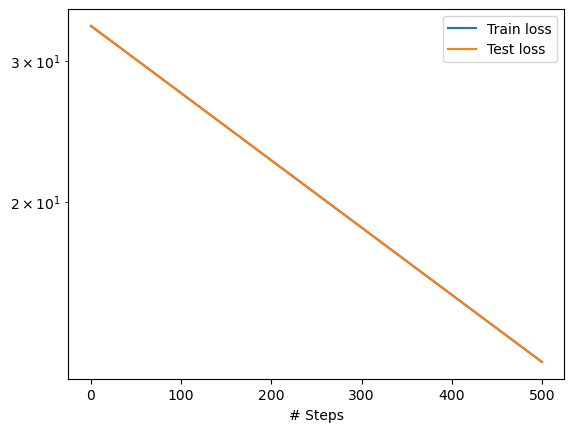

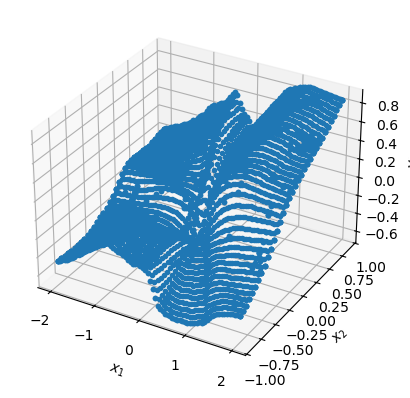

Compiling model...
Building feed-forward neural network...
'build' took 0.112546 s

'compile' took 1.236271 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.88e+01, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.88e+01, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [5.87e+00, 8.30e+00, 1.46e-01, 8.58e-03, 2.15e+00, 3.59e+00]    [5.87e+00, 8.30e+00, 1.46e-01, 8.58e-03, 2.15e+00, 3.59e+00]    []  

Best model at step 500:
  train loss: 2.01e+01
  test loss: 2.01e+01
  test metric: []

'train' took 24.436282 s



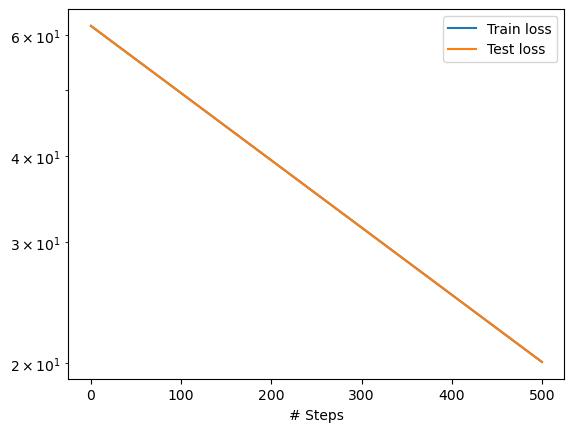

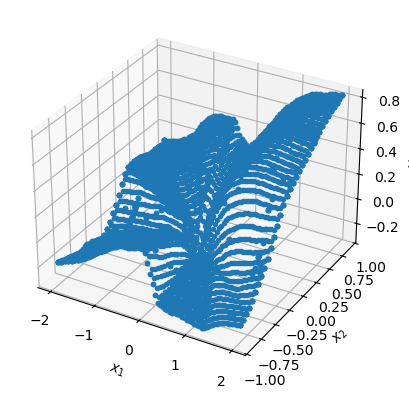

Compiling model...
Building feed-forward neural network...
'build' took 0.144190 s

'compile' took 1.764949 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.88e+03, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.88e+03, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [4.85e+02, 1.40e+01, 1.16e-01, 4.25e-02, 1.48e+00, 9.40e+00]    [4.85e+02, 1.40e+01, 1.16e-01, 4.25e-02, 1.48e+00, 9.40e+00]    []  

Best model at step 500:
  train loss: 5.10e+02
  test loss: 5.10e+02
  test metric: []

'train' took 27.660106 s



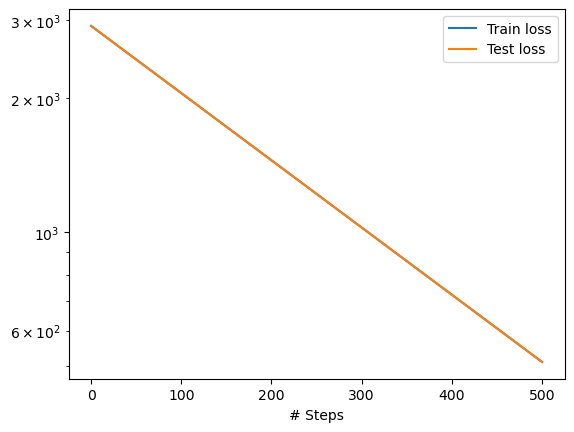

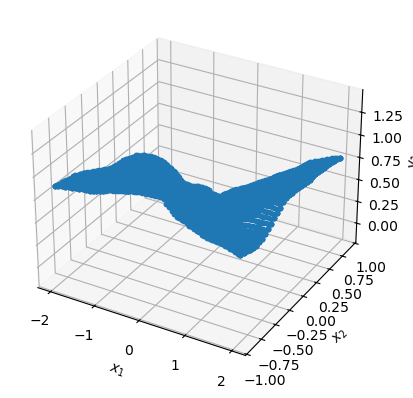

Compiling model...
Building feed-forward neural network...
'build' took 0.321748 s

'compile' took 2.426695 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.88e+05, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.88e+05, 2.08e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [4.90e+04, 1.42e+01, 1.10e-01, 4.36e-02, 1.46e+00, 9.60e+00]    [4.90e+04, 1.42e+01, 1.10e-01, 4.36e-02, 1.46e+00, 9.60e+00]    []  

Best model at step 500:
  train loss: 4.91e+04
  test loss: 4.91e+04
  test metric: []

'train' took 31.919168 s



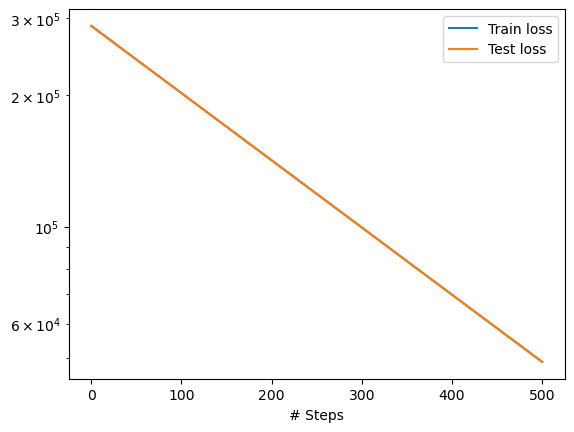

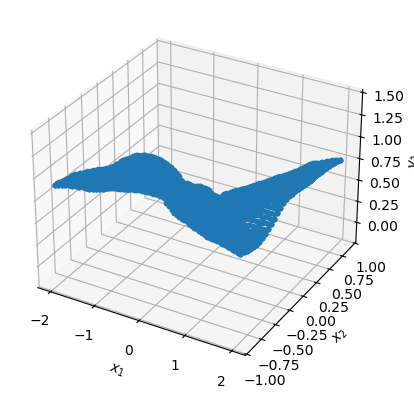

In [54]:
models_list = []
list_name = []

for idx, pde_weight in enumerate(weights):

    north_mean = dde.Variable(-1.0)
    south_mean = dde.Variable(-2.0)
    D = dde.Variable(1.0)

    bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
    bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

    periodic_condition = dde.icbc.PeriodicBC(geom = geometry_rectangle, component_x = 0, on_boundary = periodic_boundary, derivative_order= 0)
    periodic_condition_derivative = dde.icbc.PeriodicBC(geom = geometry_rectangle, component_x = 0, on_boundary = periodic_boundary, derivative_order= 1)

    data_observ_points_Holocene, observe_u_Holocene = training_points(df_empirical_Holocene)

    name = 'model_empirical_Holocene_' + str(idx)
    model_empirical_Holocene, params, best_step = train_process(data_observ_points_Holocene, observe_u_Holocene, D, bc_1, bc_2, name, pde_weight)

    models_list.append(model_empirical_Holocene)
    list_name.append(name)

Apply the PINN to a global grid to reconstruct the dust deposition rates and save the results.

In [55]:
def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values/90)
    U_pred_denorm = (U_pred + mean)*std
    # Add the value of the prediction of the PINN in the specific location
    df_to_predict['PINN_log_dep'] = U_pred_denorm

    # Save the dataset with the prediction
    with open(path+filename, 'w') as f:
        df_to_predict.to_csv(f, index=False)

In [56]:
for idx, model in enumerate(models_list):

    mean = df_empirical_Holocene['log_dep'].mean()
    std = df_empirical_Holocene['log_dep'].std()

    # PINN reconstruction on the global grid
    calculate_save_df(model, df_global_grid, mean, std, RESULTS_PATH, "df_pinn_empirical_Holocene_sensitivity_"+str(idx)+".csv")

## Perform sensitivity analysis of the PINN for the LGM

Perform the training process for the LGM, for each of the model weights.

Notice that training the neural network is resource expensive and may take minutes to hours depending on the computer facilities.

Compiling model...
Building feed-forward neural network...
'build' took 0.242761 s

'compile' took 4.469507 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [0.00e+00, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [0.00e+00, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [0.00e+00, 7.78e+00, 3.45e-02, 1.11e-02, 2.39e+00, 2.03e+00]    [0.00e+00, 7.78e+00, 3.45e-02, 1.11e-02, 2.39e+00, 2.03e+00]    []  

Best model at step 500:
  train loss: 1.22e+01
  test loss: 1.22e+01
  test metric: []

'train' took 22.300111 s



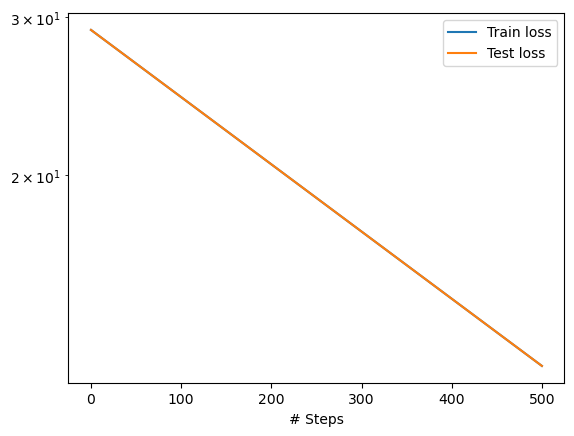

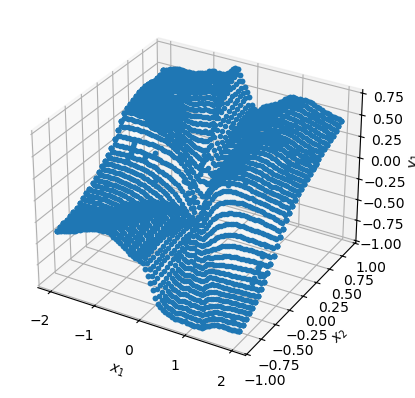

Compiling model...
Building feed-forward neural network...
'build' took 0.129129 s

'compile' took 1.752946 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.87e+01, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.87e+01, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [5.90e+00, 8.89e+00, 3.52e-02, 1.16e-02, 2.19e+00, 3.17e+00]    [5.90e+00, 8.89e+00, 3.52e-02, 1.16e-02, 2.19e+00, 3.17e+00]    []  

Best model at step 500:
  train loss: 2.02e+01
  test loss: 2.02e+01
  test metric: []

'train' took 22.026909 s



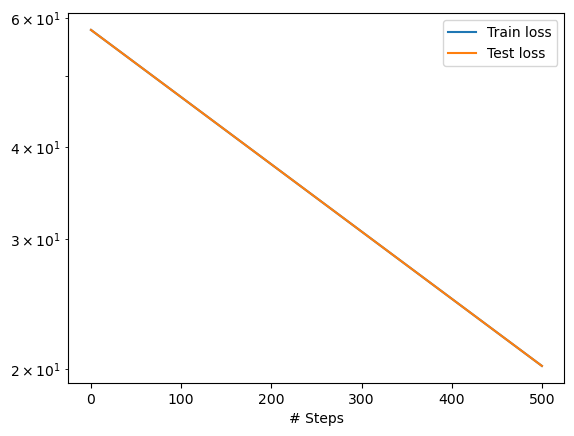

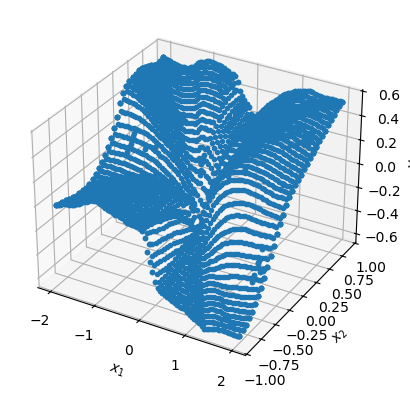

Compiling model...
Building feed-forward neural network...
'build' took 0.118700 s

'compile' took 1.665869 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.87e+03, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.87e+03, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [4.85e+02, 1.50e+01, 7.97e-02, 3.92e-02, 1.49e+00, 9.29e+00]    [4.85e+02, 1.50e+01, 7.97e-02, 3.92e-02, 1.49e+00, 9.29e+00]    []  

Best model at step 500:
  train loss: 5.11e+02
  test loss: 5.11e+02
  test metric: []

'train' took 22.088546 s



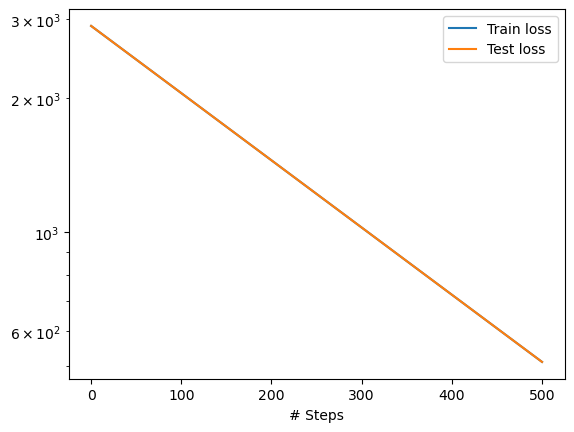

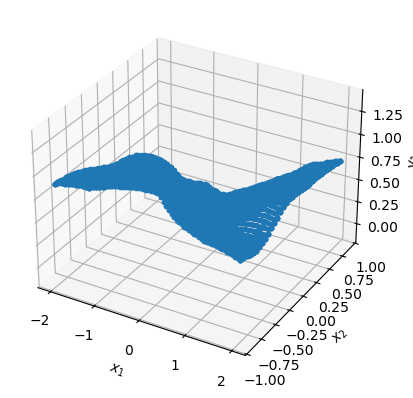

Compiling model...
Building feed-forward neural network...
'build' took 0.136988 s

'compile' took 2.119985 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.87e+05, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    [2.87e+05, 1.67e+01, 7.57e-01, 1.25e-02, 2.87e+00, 8.66e+00]    []  
500       [4.90e+04, 1.53e+01, 9.55e-02, 4.14e-02, 1.48e+00, 9.48e+00]    [4.90e+04, 1.53e+01, 9.55e-02, 4.14e-02, 1.48e+00, 9.48e+00]    []  

Best model at step 500:
  train loss: 4.90e+04
  test loss: 4.90e+04
  test metric: []

'train' took 40.354588 s



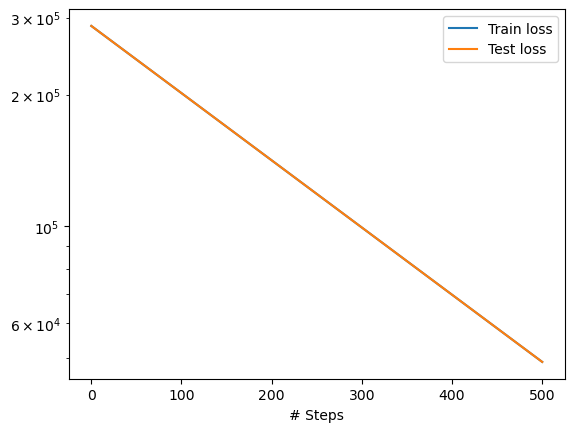

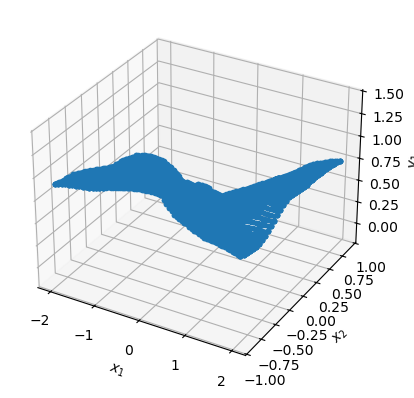

In [57]:
models_list = []
list_name = []

for idx, pde_weight in enumerate(weights):

    north_mean = dde.Variable(-1.0)
    south_mean = dde.Variable(-2.0)
    D = dde.Variable(1.0)

    bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
    bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

    periodic_condition = dde.icbc.PeriodicBC(geom = geometry_rectangle, component_x = 0, on_boundary = periodic_boundary, derivative_order= 0)
    periodic_condition_derivative = dde.icbc.PeriodicBC(geom = geometry_rectangle, component_x = 0, on_boundary = periodic_boundary, derivative_order= 1)

    data_observ_points_LGM, observe_u_LGM = training_points(df_empirical_LGM)

    name = 'model_empirical_LGM_' + str(idx)
    model_empirical_LGM, params, best_step = train_process(data_observ_points_LGM, observe_u_LGM, D, bc_1, bc_2, name, pde_weight)

    models_list.append(model_empirical_LGM)
    list_name.append(name)

Apply the PINN to a global grid to reconstruct the dust deposition rates and save the results.

In [58]:
for idx, model in enumerate(models_list):

    mean = df_empirical_LGM['log_dep'].mean()
    std = df_empirical_LGM['log_dep'].std()

    # PINN reconstruction on the global grid
    calculate_save_df(model, df_global_grid, mean, std, RESULTS_PATH, "df_pinn_empirical_LGM_sensitivity_"+str(idx)+".csv")